In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from Utilities import *
import copy
from scipy.special import rel_entr
from scipy.special import softmax
import matplotlib as mpl
import scipy.stats as stats
import statsmodels.api as sm
import re
from scipy.optimize import minimize
from mpl_toolkits.axes_grid1 import axes_grid


In [2]:
def R_BB2LLMIN(row):
    humanRewards = np.array(row["R_BB"])
    humanClosest = []
    for rew in humanRewards:
        agentProb = [np.array(row["R"+str(depth)])[rew] for depth in range(1,9)]
        humanClosest.append(np.argmax(agentProb)+1)
    return humanClosest 

def fromListtoDist(x):
    domain = len(range(0, max(x)+1)) #il # di ricompense è differente
    dist = np.zeros(domain)
    for _x in x:
        dist[_x] += 1
    return dist

def f(x,y):
    return np.sum(rel_entr(x,y))

def calculate_kl(row, depth):
    hs_dist = row["HS_DIST"]
    #add pseudo count
    hs_dist = np.array(hs_dist) + 0.000001
    hs_dist = hs_dist / np.sum(hs_dist)
    r_dist = np.array(row[f"R{depth}"]) + 10**-5
    r_dist = r_dist / np.sum(r_dist)
    return f(hs_dist, r_dist)

def replace_multiple_spaces_with_single_space(input_string):
    return re.sub(r'\s+', ' ', input_string)

def getTheDistrAsList(series):
    return [val for val in series if not np.isnan(val)]

def extract_info(column_name):
    pattern = r'PD([a-zA-Z0-9]*)(\d+)Epsilon(\d+\.\d+)BETA(\d+\.\d+)ITMAX500'
    match = re.match(pattern, column_name)
    if match:
        result = match.groups()
        model = result[0]
        depth = int(result[1])
        epsilon = float(result[2])
        beta = float(result[3])
        return model, depth, epsilon, beta
    else:
        raise ValueError("Column name does not match expected pattern.")

def log_likelihood(pmfs, data):

    # Initialize log-likelihood
    log_likelihood_value = 0.0
    #Add pseudo count to pmfs
    pmfs = np.array(pmfs) + 10**-10
    pmfs = pmfs / np.sum(pmfs)

    # Compute the log-likelihood
    for datum in data:
        log_likelihood_value += np.log(pmfs[datum])

    return log_likelihood_value

def getQuiteEasyending(graph):
    start = [n for n in graph.nodes() if graph.nodes[n]["start"] == 1][0]
    #print("start: ", start)
    #For all the nodes with reward 1, check the degree of the neighbors
    for node in graph.nodes():
        if graph.nodes()[node]["reward"] == 1:
            if graph.degree(node) - len([n  for n in graph.neighbors(node) if graph.degree(n) == 1]) == 1:
                #The node has only one neighbor with degree 1 except for one.
                #The current node cannot be a neighbor of the easyEnding
                if start in graph.neighbors(node):
                    continue
                else:   
                    #print("easy ending: ", node)
                    return "easyEnding"
    return "nonEasyEnding"

def extractBaclvsForw(inputString):
    model = inputString[3:7]
    return model

## ASSESS THE MINIMUM DEPTH TO SOLVE A PROBLEM

In [3]:
#Import old Rdf.csv
Rdf = pd.read_csv("Rdf.csv")

#Initialize new Rdf
RdfV2 = pd.DataFrame()
RdfV2["TrialID"] = Rdf.TrialID.unique()
RdfV2["N_REWARDS"] = [Rdf.loc[Rdf.TrialID == TrialID, "N_REWARDS"].values[0] for TrialID in RdfV2.TrialID]
RdfV2["R_BB"] = [Rdf.loc[Rdf.TrialID == TrialID, "R_BB"].values[0] for TrialID in RdfV2.TrialID]
RdfV2["R_BB"] = RdfV2["R_BB"].apply(lambda x: [int(n) for n in x[1:-1].split(", ")])
RdfV2["HS_DIST"] = [Rdf.loc[Rdf.TrialID == TrialID, "HS_DIST"].values[0] for TrialID in RdfV2.TrialID]
RdfV2["HS_DIST"] = RdfV2["HS_DIST"].apply(lambda x: replace_multiple_spaces_with_single_space(x)[1:-1].split(" "))
for row in range(len(RdfV2)):
    RdfV2.at[row, "HS_DIST"] = np.array([float(n) for n in RdfV2.loc[row, "HS_DIST"] if n != ''], dtype= np.float64)
RdfV2["SubjID"] = [Rdf.loc[Rdf.TrialID == TrialID, "SubjID"].values[0] for TrialID in RdfV2.TrialID]

#Find and remove trial problems
problemList = list(np.loadtxt("./problemList.txt", dtype = str))
problemListOriginal = list(np.loadtxt("./problemList.txt", dtype = str))
indexesToRemove = []
for i, problem in enumerate(problemList):
    if problem[:-10] not in Rdf.TrialID.unique():
        indexesToRemove.append(i)
problemList = [problemList[i] for i in range(len(problemList)) if i not in indexesToRemove]

In [4]:
#Import of performance of different models
epsilon = 0.0
BETALs = [100.]
IT_MAX = 500

columnNames = []
PDs = []
for depth in range(1, 9):
    BETA = BETALs[0]
    columnName = "PD_BACKWARD" +str(depth) + "Epsilon" +str(epsilon) + "BETA" + str(BETA) + "ITMAX" + str(IT_MAX)
    columnNames.append(columnName)
    PD = pd.read_csv("./PD_V18/PD_ARGMAX_BACKWARD_" +str(depth) + "Epsilon" +str(epsilon) + "BETA" + str(BETA)+ "ITMAX" + str(IT_MAX) + ".csv", index_col = 0)
    #Drop the indexes that are not in Rdf
    PD = PD.drop(indexesToRemove)
    #Reset the indexes
    PD = PD.reset_index(drop=True)
    #Drop Unnamed: 0.1 column
    if "Unnamed: 0.1" in PD.columns:
        PD = PD.drop(columns = ["Unnamed: 0.1"])
    PDs.append(PD)
    RdfV2[columnName] = PD.apply(lambda x: getTheDistrAsList(x), axis = 1)

#Get the minimum depth for each trial for this model
nonNull = []
for TrialIndex in range(90):
    N_REWARDS = RdfV2.loc[TrialIndex, "N_REWARDS"]
    nonNull += [np.min([depth for depth in range(1, N_REWARDS+1) if PDs[depth-1].loc[TrialIndex, str(N_REWARDS)] > 0])]
nonNullDict = {problem[:-10]: nonNull[i] for i, problem in enumerate(problemList)}
#Dataframe with the minimum depth for each trial
minDepth = pd.DataFrame()
minDepth["TrialID"] = RdfV2.TrialID
minDepth["minDepth"] = nonNull
#Add the minimum depth to the dataframe
RdfV2["MinAgentBACKWARD"] = minDepth["minDepth"]
for columnName in columnNames:
    RdfV2[columnName + "LL"] = RdfV2.apply(lambda x: log_likelihood(x[columnName], x["R_BB"]), axis = 1)

columnNamesFORWARD = []
PDs = []
for depth in range(1, 9):
    BETA = BETALs[0]
    columnName = "PD_FORWARD" +str(depth) + "Epsilon" +str(epsilon) + "BETA" + str(BETA) + "ITMAX" + str(IT_MAX)
    columnNamesFORWARD.append(columnName)
    PD = pd.read_csv("./PD_V18/PD_NO_BACKWARD_" +str(depth) + "Epsilon" +str(epsilon) + "BETA" + str(BETA)+ "ITMAX" + str(IT_MAX) + ".csv", index_col = 0)
    #Drop the indexes that are not in Rdf
    PD = PD.drop(indexesToRemove)
    #Reset the indexes
    PD = PD.reset_index(drop=True)
    #Drop Unnamed: 0.1 column
    if "Unnamed: 0.1" in PD.columns:
        PD = PD.drop(columns = ["Unnamed: 0.1"])
    PDs.append(PD)
    RdfV2[columnName] = PD.apply(lambda x: getTheDistrAsList(x), axis = 1)

#Get the minimum depth for each trial for this model
nonNull = []
for TrialIndex in range(90):
    N_REWARDS = RdfV2.loc[TrialIndex, "N_REWARDS"]
    nonNull += [np.min([depth for depth in range(1, N_REWARDS+1) if PDs[depth-1].loc[TrialIndex, str(N_REWARDS)] > 0])]
nonNullDict = {problem[:-10]: nonNull[i] for i, problem in enumerate(problemList)}
#Dataframe with the minimum depth for each trial
minDepth = pd.DataFrame()
minDepth["TrialID"] = RdfV2.TrialID
minDepth["minDepth"] = nonNull
#Add the minimum depth to the dataframe
RdfV2["MinAgentFORWARD"] = minDepth["minDepth"]
for columnName in columnNamesFORWARD:
    RdfV2[columnName + "LL"] = RdfV2.apply(lambda x: log_likelihood(x[columnName], x["R_BB"]), axis = 1)

In [5]:
Rdf = RdfV2
Rdf["DepthIDFORWARD"] = Rdf["MinAgentFORWARD"].apply(lambda x: 1 if x == 1 else 2 if x == 2 or x == 3 or x == 4 else 3)
#Make a dictionary with TrialID and MinAgentFORWARD
minAgentDict = {Rdf.loc[i, "TrialID"]: int(Rdf.loc[i, "DepthIDFORWARD"]) for i in range(len(Rdf))}
#Save it
with open("minAgentDict.json", "w") as f:
    json.dump(minAgentDict, f)

##  FIGURE S 13: BACKWARD vs FORWARD

In [6]:
for TrialID in Rdf.TrialID.unique():
    #Find the column with the highest log likelihood
    columnNamesLL = [columnName + "LL" for columnName in  columnNames]
    #Consider only the columns in columnNamesLL and easyEnding == "easyEnding"
    Rdf.loc[(Rdf.TrialID == TrialID), "BestModelBACKWARD"] = Rdf.loc[Rdf.TrialID == TrialID, columnNamesLL].idxmax(axis = 1).values[0]
    #Find the column with the highest log likelihood
    columnNamesLLFORWARD = [columnName + "LL" for columnName in  columnNamesFORWARD]
    #Consider only the columns in columnNamesLL and easyEnding == "easyEnding"
    Rdf.loc[(Rdf.TrialID == TrialID), "BestModelFORWARD"] = Rdf.loc[Rdf.TrialID == TrialID, columnNamesLLFORWARD].idxmax(axis = 1).values[0]

In [7]:
for TrialID in Rdf.TrialID.unique():
    bestForward = Rdf.loc[(Rdf.TrialID == TrialID), "BestModelFORWARD"].values[0]
    bestBackward = Rdf.loc[(Rdf.TrialID == TrialID), "BestModelBACKWARD"].values[0] 
    #Compare the likelihood of the best forward and backward model
    if Rdf.loc[(Rdf.TrialID == TrialID), bestForward].values[0] > Rdf.loc[(Rdf.TrialID == TrialID), bestBackward].values[0]:
        Rdf.loc[(Rdf.TrialID == TrialID), "BestModel"] = bestForward
    if Rdf.loc[(Rdf.TrialID == TrialID), bestForward].values[0] < Rdf.loc[(Rdf.TrialID == TrialID), bestBackward].values[0]:
        Rdf.loc[(Rdf.TrialID == TrialID), "BestModel"] = bestBackward
    if Rdf.loc[(Rdf.TrialID == TrialID), bestForward].values[0] == Rdf.loc[(Rdf.TrialID == TrialID), bestBackward].values[0]:
        Rdf.loc[(Rdf.TrialID == TrialID), "BestModel"] = "Undistinguishable"

In [8]:
Rdf["BestModelType"] = Rdf["BestModel"].apply(lambda x: extractBaclvsForw(x))

In [9]:
Rdf["BestModelType"].value_counts()

isti    46
FORW    23
BACK    21
Name: BestModelType, dtype: int64

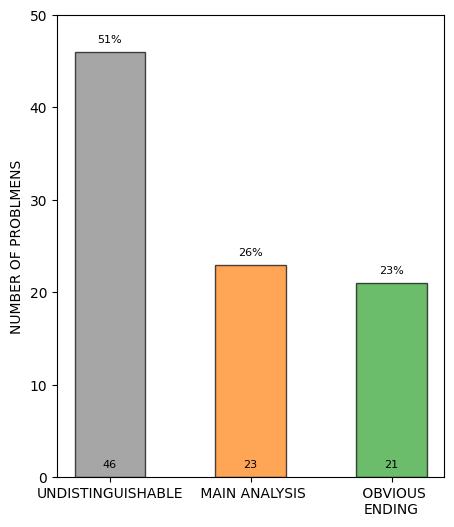

In [10]:
counts = Rdf["BestModelType"].value_counts()
categories = ["UNDISTINGUISHABLE","FORWARD", "BACKWARD"]
colors = ["GREY", "#ff7f0e", "#2ca02c"]
fig, ax = plt.subplots(figsize = (5, 6))
#BOXPLOT
ax.bar(categories, counts, color = colors, alpha = 0.7, edgecolor = "black", width=0.5)
ax.set_xticks(categories, ["UNDISTINGUISHABLE"," MAIN ANALYSIS", " OBVIOUS\nENDING"], fontsize = 10)
ax.set_ylabel("NUMBER OF PROBLMENS", fontsize = 10)
#ax.set_title("MODEL COMPARISON", fontsize = 10)
#PRINT ALSO THE PERCENTAGE
for i, count in enumerate(counts):
    ax.text(i, count + 1, str(round(count/90*100.))+ "%", ha = "center", fontsize = 8)
#Print th ecount down the bars
for i, count in enumerate(counts):
    ax.text(i, 1, str(int(count)), ha = "center", fontsize = 8)
ax.set_ylim(0,50)
#save the figure
#plt.savefig("./IMAGES/FigureS13.png", dpi = 300)
plt.show()

In [11]:
#Use extract_info to get the model, depth and epsilon from BestModel column
#Rdf["BestModel"] = Rdf["BestModel"].apply(lambda x: extract_info(x))
#Rdf["BestModelModel"] = Rdf["BestModel"].apply(lambda x: x[0] if x is not None else None)
Rdf["BestDepthFORWARD"] = Rdf["BestModelFORWARD"].apply(lambda x: x[10] if x is not None else None)
Rdf["BestDepthBACKWARD"] = Rdf["BestModelBACKWARD"].apply(lambda x: x[11] if x is not None else None)
Rdf["BestEpsilon"] = 0.0# Rdf["BestModel"].apply(lambda x: x[2] if x is not None else None)
Rdf["BestBeta"] = 100. #Rdf["BestModel"].apply(lambda x: x[3] if x is not None else None)

## FIGURE 5: LOG LIKELIHOOD PROBLEM BY PROBLEM

<Figure size 2000x1500 with 0 Axes>

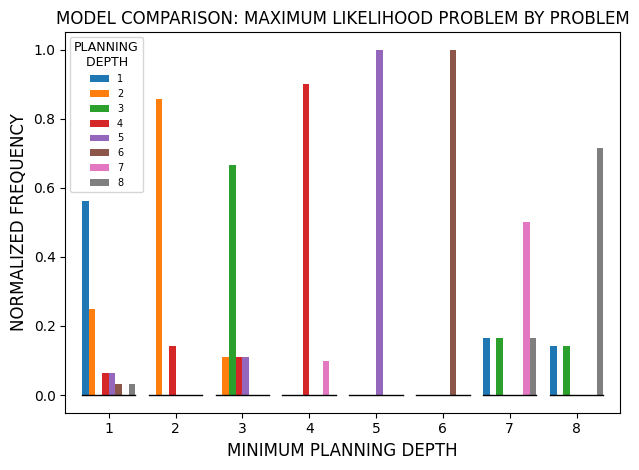

In [12]:
df_grouped = Rdf.groupby("MinAgentFORWARD").BestDepthFORWARD.value_counts().unstack().fillna(0)

# Normalize the DataFrame by dividing each value by the sum of its row
df_normalized = df_grouped.div(df_grouped.sum(axis=1), axis=0)

plt.figure(figsize=(20, 15))
ax = df_normalized.plot(kind="bar", width=0.8, legend=True)
plt.xticks(rotation=0)
plt.ylabel("NORMALIZED FREQUENCY", fontdict={'fontsize': 12})
plt.xlabel("MINIMUM PLANNING DEPTH", fontdict={'fontsize': 12})
plt.title("MODEL COMPARISON: MAXIMUM LIKELIHOOD PROBLEM BY PROBLEM", fontdict={'fontsize': 12})
plt.tight_layout()

# make the legend smaller and set a title and set the legend outside the plot
plt.legend(title="PLANNING\n   DEPTH", fontsize=7, title_fontsize=9, loc='upper left')
# Add brackets above each x-tick
group_labels = df_normalized.index.tolist()
x_ticks = np.arange(len(group_labels))
bar_width = 0.8
for i, tick in enumerate(x_ticks):
    ax.plot([tick - bar_width / 2, tick + bar_width / 2], [-.001, -.001], color='black', lw=1)
    #ax.text(tick, -.15, group_labels[i], ha='center', va='bottom', fontsize=10)
#Supertitle
#plt.savefig("./IMAGES/Figure5.png", dpi=300)
plt.show()

## FIGURE 6: RANK FORWARD

In [ ]:
columnsTBRankedLs = []
for TrialID in Rdf.TrialID.unique():
    #bestModel = Rdf.loc[Rdf.TrialID == TrialID, "BestModelType"].values[0]
    bestModel = "_FORWARD"
    bestBeta = Rdf.loc[Rdf.TrialID == TrialID, "BestBeta"].values[0]
    columnsTBRankedLs.append(["PD" +bestModel +str(depth) + "Epsilon" +str(epsilon) + "BETA" + str(bestBeta) + "ITMAX" + str(IT_MAX) for depth in range(1, 9)])
averageRanks = np.zeros((len(Rdf.TrialID.unique()), 9))
for trialIndex, TrialID in enumerate(Rdf.TrialID.unique()):
    for columnNameLs in columnsTBRankedLs:
        #Get the loglikelihoods of columnNameLs
        logLikelihoods = Rdf.loc[Rdf.TrialID == TrialID, [columnName for columnName in columnNamesLLFORWARD]].values[0]
        #Add small noise to avoid ties
        #logLikelihoods += np.random.normal(0, 10**-10, len(logLikelihoods))
        depthRanked = np.argsort(-logLikelihoods) + 1
        for depth in range(1, 9):
            averageRanks[trialIndex, depth-1] = np.where(depthRanked == depth)[0][0]
        averageRanks[trialIndex, -1] = np.where(depthRanked ==  Rdf.loc[Rdf.TrialID == TrialID, "MinAgentFORWARD"].values[0])[0][0]

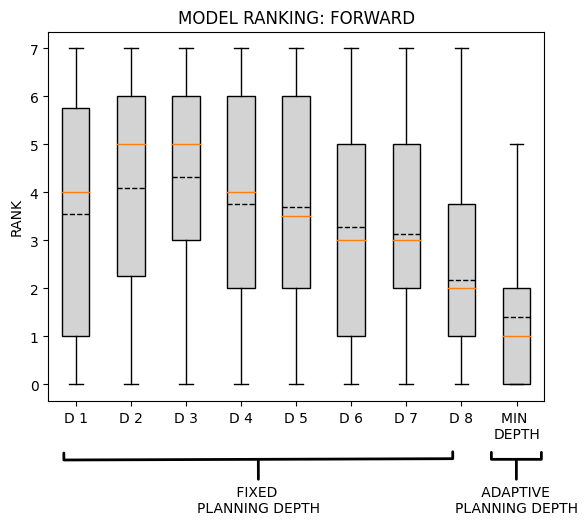

In [19]:
#Make a boxplot of average ranks showing the distribution of the ranks
fig, ax = plt.subplots()
ax.boxplot(averageRanks, showfliers = False, patch_artist = True, showmeans=True, meanline=True, meanprops = dict(color = "black"), boxprops=dict(facecolor="lightgrey"))
#For eahc boxplot scatter the points    
#for i, depth in enumerate(range(1, 10)):
#   ax.scatter(np.random.normal(i+1, 0.1, len(averageRanks[:,i])), averageRanks[:,i], alpha = 0.01, c = "k")
ax.set_xticks(range(1, 10), ["D " + str(depth) for depth in range(1, 9)]  + ["MIN \nDEPTH"])
ax.set_ylabel("RANK")
ax.set_title("MODEL RANKING: FORWARD")
#Annotate 
#ax.text(3, -2, "FIXED\nPLANNING DEPTH", fontsize = 10)
#ax.text(8, -2.7, "      ADAPTIVE\nPLANNING DEPTH", fontsize = 10)
ax.annotate('         FIXED\nPLANNING DEPTH', xy=(0.4237, -0.15), xytext=(0.3, -0.3), xycoords='axes fraction', 
            arrowprops=dict(arrowstyle='-[, widthB=14.0, lengthB=0.5', lw=2.0, color='k'))
ax.annotate('      ADAPTIVE\nPLANNING DEPTH', xy=(0.944, -0.15), xytext=(0.82, -0.3), xycoords='axes fraction', 
            arrowprops=dict(arrowstyle='-[, widthB=1.8, lengthB=0.5', lw=2.0, color='k'))
#save the figure
#plt.savefig("./IMAGES/Figure6.png", dpi = 300, bbox_inches = "tight")
plt.show()

In [20]:
rank = np.transpose(averageRanks)
#Get the frequency of each occurence of each rank
rankFreq = np.zeros((9, 8))
for modelIndex in range(9):
    for rankIndex in range(8):
        rankFreq[modelIndex, rankIndex] = np.sum(rank[modelIndex] == rankIndex)
#get the p-values of chi2 indipendence test of rankFreq[0] and rankFreq[-1]
for depth in range(0, 8):
    chi2, p, _, _ = stats.chi2_contingency(rankFreq[[depth, -1]])
    print("D =", depth, p, chi2)

D = 0 4.5058513670436237e-07 42.32300640902241
D = 1 1.5279393503692922e-11 64.96562060230791
D = 2 3.6167074941072736e-12 68.07407655475498
D = 3 1.2641997838995097e-08 50.29483335107301
D = 4 6.9211811704898596e-09 51.62502799686309
D = 5 2.41741278404528e-06 38.515646258503395
D = 6 1.154411039805309e-06 40.196363636363635
D = 7 0.004513762777103384 20.540196645459805


## AVOID TIES

In [28]:
from scipy.stats import chi2_contingency

In [57]:
columnsTBRankedLs = [
    [f"PD_FORWARD{depth}Epsilon{epsilon}BETA{bestBeta}ITMAX{IT_MAX}" 
     for depth in range(1, 9)]
    for bestBeta, epsilon, IT_MAX in zip(Rdf["BestBeta"], [0] * len(Rdf), [100] * len(Rdf))
]

unique_trial_ids = Rdf.TrialID.unique()
num_trials = len(unique_trial_ids)

# Precompute log-likelihood columns for all trials
log_likelihood_data = {
    TrialID: Rdf.loc[Rdf.TrialID == TrialID, columnNamesLLFORWARD].values[0]
    for TrialID in unique_trial_ids
}

verified = 0
N_REPLICA = 100000
totalReplicas = N_REPLICA
for replica in range(N_REPLICA):
    #print(replica)
    averageRanks = np.zeros((num_trials, 9))
    
    for trialIndex, TrialID in enumerate(unique_trial_ids):
        logLikelihoods = log_likelihood_data[TrialID]
        
        # Add small noise to avoid ties
        logLikelihoods += np.random.normal(0, 10**-12, len(logLikelihoods))
        depthRanked = np.argsort(-logLikelihoods) + 1
        
        # Compute average ranks for depths 1-8
        averageRanks[trialIndex, :8] = [np.where(depthRanked == depth)[0][0] for depth in range(1, 9)]
        # Compute rank for MinAgentFORWARD
        min_agent_rank = Rdf.loc[Rdf.TrialID == TrialID, "MinAgentFORWARD"].values[0]
        averageRanks[trialIndex, 8] = np.where(depthRanked == min_agent_rank)[0][0]

    rankFreq = np.zeros((9, 8))
    rank = np.transpose(averageRanks)
    
    for modelIndex in range(9):
        for rankIndex in range(8):
            rankFreq[modelIndex, rankIndex] = np.sum(rank[modelIndex] == rankIndex)
    
    # Perform chi-squared tests for ranks
    for depth in range(8):
        try:
            chi2, p, _, _ = chi2_contingency(rankFreq[[depth, -1]])
            if p > 0.05:
                verified += 1
                #print(f"Verified at depth {depth} with p-value {p}")
                break
        except:
            totalReplicas -= 1
            pass

print(verified / (totalReplicas + 1))

0.006519934800651993


100000

## FIGURE S14: RANK BACKWARD

<Figure size 2000x1500 with 0 Axes>

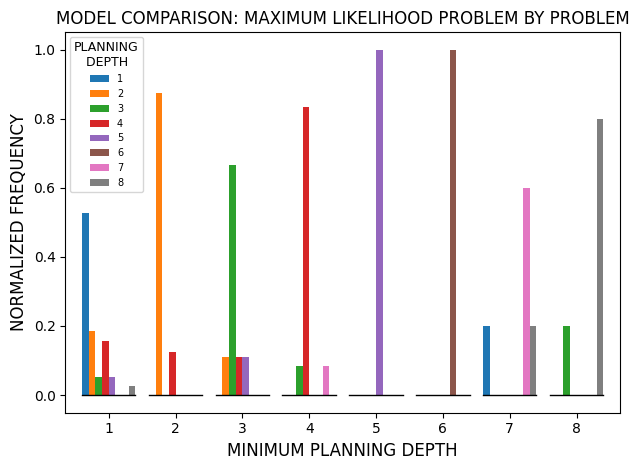

In [60]:
df_grouped = Rdf.groupby("MinAgentBACKWARD").BestDepthBACKWARD.value_counts().unstack().fillna(0)

# Normalize the DataFrame by dividing each value by the sum of its row
df_normalized = df_grouped.div(df_grouped.sum(axis=1), axis=0)

plt.figure(figsize=(20, 15))
ax = df_normalized.plot(kind="bar", width=0.8, legend=True)
plt.xticks(rotation=0)
plt.ylabel("NORMALIZED FREQUENCY", fontdict={'fontsize': 12})
plt.xlabel("MINIMUM PLANNING DEPTH", fontdict={'fontsize': 12})
plt.title("MODEL COMPARISON: MAXIMUM LIKELIHOOD PROBLEM BY PROBLEM", fontdict={'fontsize': 12})
plt.tight_layout()

# make the legend smaller and set a title and set the legend outside the plot
plt.legend(title="PLANNING\n   DEPTH", fontsize=7, title_fontsize=9, loc='upper left')
# Add brackets above each x-tick
group_labels = df_normalized.index.tolist()
x_ticks = np.arange(len(group_labels))
bar_width = 0.8
for i, tick in enumerate(x_ticks):
    ax.plot([tick - bar_width / 2, tick + bar_width / 2], [-.001, -.001], color='black', lw=1)
    #ax.text(tick, -.15, group_labels[i], ha='center', va='bottom', fontsize=10)
#Supertitle
plt.savefig("./IMAGES/FigureS14.png", dpi=300)
plt.show()

## FIGURE S15: RANK FORWARD

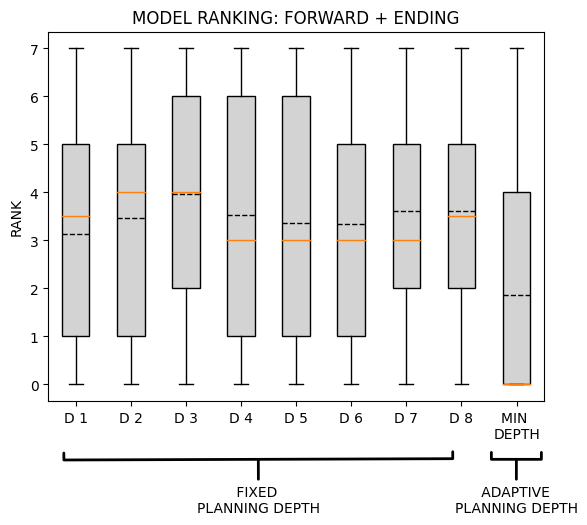

D = 0 4.998077390035018e-05 31.5133467152043
D = 1 3.993797057588699e-06 37.368496294839005
D = 2 2.777808980293938e-08 48.551226258528494
D = 3 5.114730130156846e-06 36.80148547702727
D = 4 9.934241002051996e-06 35.27376600008179
D = 5 8.788673417513886e-10 56.157330630651856
D = 6 2.047483308149449e-11 64.3328307697348
D = 7 4.944127016181325e-10 57.414610103854955


In [61]:
columnsTBRankedLs = []
for TrialID in Rdf.TrialID.unique():
    #bestModel = Rdf.loc[Rdf.TrialID == TrialID, "BestModelType"].values[0]
    bestModel = "_BACKWARD"
    bestBeta = Rdf.loc[Rdf.TrialID == TrialID, "BestBeta"].values[0]
    columnsTBRankedLs.append(["PD" +bestModel +str(depth) + "Epsilon" +str(epsilon) + "BETA" + str(bestBeta) + "ITMAX" + str(IT_MAX) for depth in range(1, 9)])
averageRanks = np.zeros((len(Rdf.TrialID.unique()), 9))
for trialIndex, TrialID in enumerate(Rdf.TrialID.unique()):
    for columnNameLs in columnsTBRankedLs:
        #Get the loglikelihoods of columnNameLs
        logLikelihoods = Rdf.loc[Rdf.TrialID == TrialID, [columnName for columnName in columnNamesLLFORWARD]].values[0]
        depthRanked = np.argsort(-logLikelihoods) + 1
        for depth in range(1, 9):
            averageRanks[trialIndex, depth-1] = np.where(depthRanked == depth)[0][0]
        averageRanks[trialIndex, -1] = np.where(depthRanked ==  Rdf.loc[Rdf.TrialID == TrialID, "MinAgentBACKWARD"].values[0])[0][0]

#Make a boxplot of average ranks showing the distribution of the ranks
fig, ax = plt.subplots()
ax.boxplot(averageRanks, showfliers = False, patch_artist = True, showmeans=True, meanline=True, meanprops = dict(color = "black"), boxprops=dict(facecolor="lightgrey"))
#For eahc boxplot scatter the points    
#for i, depth in enumerate(range(1, 10)):
#   ax.scatter(np.random.normal(i+1, 0.1, len(averageRanks[:,i])), averageRanks[:,i], alpha = 0.01, c = "k")
ax.set_xticks(range(1, 10), ["D " + str(depth) for depth in range(1, 9)]  + ["MIN \nDEPTH"])
ax.set_ylabel("RANK")
ax.set_title("MODEL RANKING: FORWARD + ENDING")
#Annotate 
#ax.text(3, -2, "FIXED\nPLANNING DEPTH", fontsize = 10)
#ax.text(8, -2.7, "      ADAPTIVE\nPLANNING DEPTH", fontsize = 10)
ax.annotate('         FIXED\nPLANNING DEPTH', xy=(0.4237, -0.15), xytext=(0.3, -0.3), xycoords='axes fraction', 
            arrowprops=dict(arrowstyle='-[, widthB=14.0, lengthB=0.5', lw=2.0, color='k'))
ax.annotate('      ADAPTIVE\nPLANNING DEPTH', xy=(0.944, -0.15), xytext=(0.82, -0.3), xycoords='axes fraction', 
            arrowprops=dict(arrowstyle='-[, widthB=1.8, lengthB=0.5', lw=2.0, color='k'))
#save the figure with a tight layout
#plt.tight_layout()
#plt.savefig("./PD_V18/ModelRankingFORWARD.png", dpi = 300, bbox_inches = "tight")
plt.savefig("./IMAGES/FigureS15.png", dpi = 300, bbox_inches = "tight")
plt.show()

rank = np.transpose(averageRanks)
#Get the frequency of each occurence of each rank
rankFreq = np.zeros((9, 8))
for modelIndex in range(9):
    for rankIndex in range(8):
        rankFreq[modelIndex, rankIndex] = np.sum(rank[modelIndex] == rankIndex)
#get the p-values of chi2 indipendence test of rankFreq[0] and rankFreq[-1]
for depth in range(0, 8):
    chi2, p, _, _ = stats.chi2_contingency(rankFreq[[depth, -1]])
    print("D =", depth, p, chi2)

## FIGURE S3: D_KL PER LEVEL

In [62]:
problemList = [problem[:-10] for problem in problemList]

In [63]:
#Make a map problemList -> Level 
problemListDict = {}
for index, problem in enumerate(problemList):
    if index < 30:
        problemListDict[problem] = 1
    if index >= 30 and index < 60:
        problemListDict[problem] = 2
    if index >= 60:
        problemListDict[problem] = 3

In [64]:
#Create a Level column in Rdf
Rdf["Level"] = Rdf["TrialID"].apply(lambda x: problemListDict[x])

In [65]:
heatmapLs = []
for Level in range(1,4):
    heatmap = []
    for depth in range(1, Rdf[(Rdf.Level == Level)]["N_REWARDS"].max() +1):
        myarray = Rdf[(Rdf.Level == Level) & (Rdf.MinAgentFORWARD==depth)].BestDepthFORWARD.values.astype(int)
        weights = np.ones_like(myarray)/float(len(myarray))
        heatmap.append(
            np.histogram(myarray, weights=weights, range = (0.5,Rdf[(Rdf.Level == Level)]["N_REWARDS"].max() + .5), bins = Rdf[(Rdf.Level == Level)]["N_REWARDS"].max())[0])
    heatmapLs.append(heatmap)

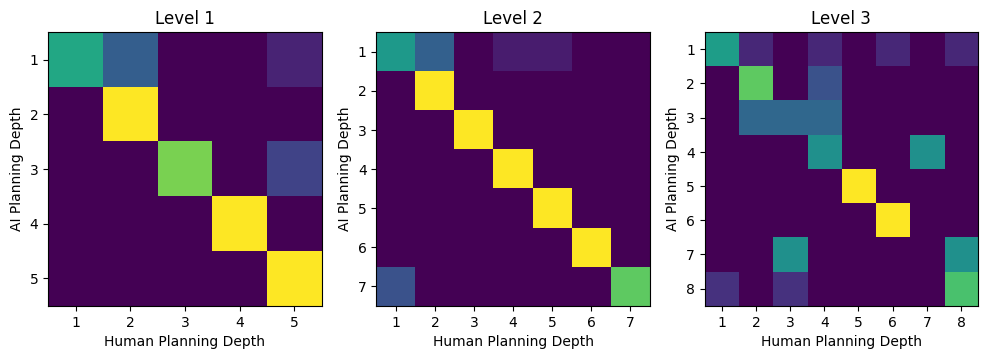

In [66]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (12,10))
maxlv = [6,8,9]
for lv in range(3):
    plt.sca(axs[lv])
    plt.imshow(heatmapLs[lv])
    plt.xticks(range(0,maxlv[lv]), range(1,maxlv[lv]+1))
    plt.yticks(range(0,maxlv[lv]), range(1,maxlv[lv]+1))
    plt.ylim(maxlv[lv]-1.5, -.5)
    plt.xlim( -.5, maxlv[lv]-1.5)
    #plt.ylabel("Minimal Solving Depth")
    plt.ylabel("AI Planning Depth")
    #plt.xlabel("Most Similar Solving Depth")
    plt.xlabel("Human Planning Depth")
    plt.title("Level " + str(lv + 1))
plt.savefig("IMAGES/FigureS3.png", dpi = 144)

## FIGURE S5-S12

In [67]:
supplementary = copy.deepcopy(Rdf)
columnNamesFORWARD
supplementary = supplementary[["HS_DIST", "TrialID", "N_REWARDS", "MinAgentFORWARD", 'PD_FORWARD1Epsilon0.0BETA100.0ITMAX500',
 'PD_FORWARD2Epsilon0.0BETA100.0ITMAX500',
 'PD_FORWARD3Epsilon0.0BETA100.0ITMAX500',
 'PD_FORWARD4Epsilon0.0BETA100.0ITMAX500',
 'PD_FORWARD5Epsilon0.0BETA100.0ITMAX500',
 'PD_FORWARD6Epsilon0.0BETA100.0ITMAX500',
 'PD_FORWARD7Epsilon0.0BETA100.0ITMAX500',
 'PD_FORWARD8Epsilon0.0BETA100.0ITMAX500']]

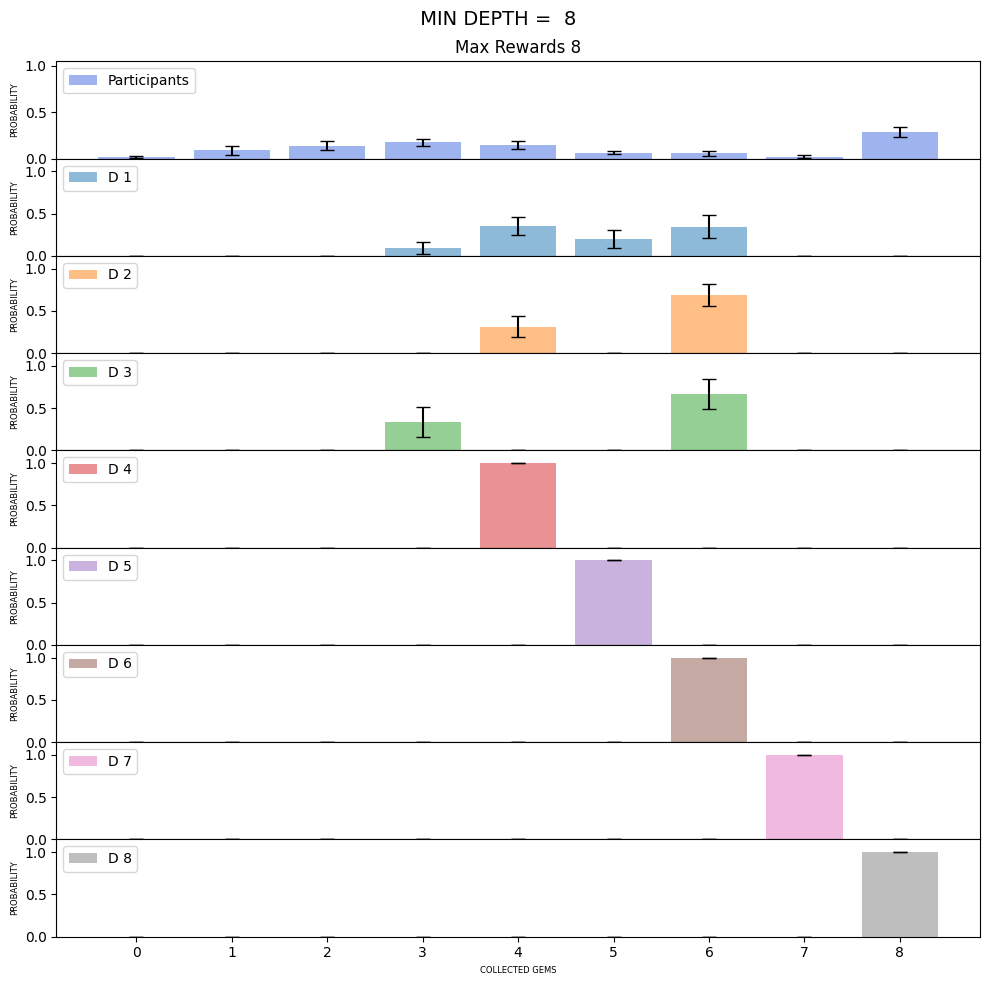

In [76]:
# Group the DataFrame by MinAgent and N_REWARDS
grouped_df = supplementary.groupby(["MinAgentFORWARD", "N_REWARDS"])[["HS_DIST", 'PD_FORWARD1Epsilon0.0BETA100.0ITMAX500',
 'PD_FORWARD2Epsilon0.0BETA100.0ITMAX500',
 'PD_FORWARD3Epsilon0.0BETA100.0ITMAX500',
 'PD_FORWARD4Epsilon0.0BETA100.0ITMAX500',
 'PD_FORWARD5Epsilon0.0BETA100.0ITMAX500',
 'PD_FORWARD6Epsilon0.0BETA100.0ITMAX500',
 'PD_FORWARD7Epsilon0.0BETA100.0ITMAX500',
 'PD_FORWARD8Epsilon0.0BETA100.0ITMAX500']]

# Plot the distributions for each group
for min_agent in [8]:
    fig = plt.figure(figsize=(10,10))
    nrows = 1
    Columns = supplementary[supplementary.MinAgentFORWARD == min_agent].N_REWARDS.unique()
    ncols = len(Columns)
    fig.suptitle(f" MIN DEPTH =  {min_agent}", fontsize = 14)
    for indexCol, max_rewards in enumerate(np.sort(Columns)):
        
        naxes = max_rewards + 1
        # Get the group for the current MinAgent and N_REWARDS
        group = grouped_df.get_group((min_agent, max_rewards))["HS_DIST"]
        # Average the distributions
        avg_dist = np.array([np.array(n) for n in group.values]).mean(axis = 0)
        sem =  stats.sem([np.array(n) for n in group.values], axis = 0)
        # Standard error of the mean
        # Plot the distribution counts in a bar chart
        ag = axes_grid.Grid(fig, (nrows, ncols, indexCol+1), (naxes, 1), axes_pad=0)
        ax = ag[0]
        ax.bar(range(len(avg_dist)), avg_dist, yerr=sem, capsize=5, label="Participants",  color = "royalblue", alpha = 0.5, width = 0.8)
        ax.legend(loc="upper left", fontsize=10)
        ax.set_ylim(0, 1.05)
        ax.set_xticks(range(0, max_rewards + 1))
        #ax.vlines(x = min_agent-.5, ymin = 0, ymax = 1, color = "k", linestyle = "--")
        #Set suptitle
        ax.set_title(f"Max Rewards {max_rewards}")
        ax.set_ylabel("PROBABILITY", fontsize = 6)
        for n_rewards in range(1, naxes):
            
            # Get the group for the current MinAgent and N_REWARDS
            group = grouped_df.get_group((min_agent, max_rewards))["PD_FORWARD"+str(n_rewards)+"Epsilon0.0BETA100.0ITMAX500"]
            # Average the distributions
            avg_dist = np.array([np.array(n) for n in group.values]).mean(axis = 0)
            sem =  stats.sem([np.array(n) for n in group.values], axis = 0)
            # Plot the distribution counts in a bar chart
            ax = ag[n_rewards]
            ax.bar(range(len(avg_dist)), avg_dist, yerr=sem, capsize=5, label=f"D {n_rewards}",  color = "C"+str(n_rewards-1), alpha = 0.5, width = 0.8)
            ax.legend(loc="upper left", fontsize=10)
            ax.set_ylim(0,1.15)
            ax.set_xticks(range(0, max_rewards + 1))
            #ax.vlines(x = min_agent-.5, ymin = 0, ymax = 1, color = "k", linestyle = "--")
            if indexCol==0:
                ax.set_ylabel("PROBABILITY", fontsize = 6)

            if n_rewards==max_rewards:
                ax.set_xlabel("COLLECTED GEMS", fontsize = 6)
            

    plt.tight_layout()
    #Remove vertical space between subplot
    plt.subplots_adjust(hspace=0.1)
    #Save
    #plt.savefig("./IMAGES/FigureS"+str(min_agent)+".png", dpi = 300)
    plt.savefig("./IMAGES/FigureS12.png", dpi = 300)
    plt.show()